# Projet

In [67]:
import pandas as pa
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from time import time

from numpy.linalg import eig, inv
import warnings
warnings.filterwarnings("ignore")

In [68]:
from keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

Classes :
|nb|name|
|--|--|
|0 |T-shirt/top|
|1 |Trouser|
|2 |Pullover|
|3 |Dress|
|4 |Coat|
|5 |Sandal|
|6 |Shirt|
|7 |Sneaker|
|8 |Bag|
|9 |Ankle boot|

In [69]:
classes = { 0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
def isA(nb: int):
  return classes[nb]

Class: Ankle boot


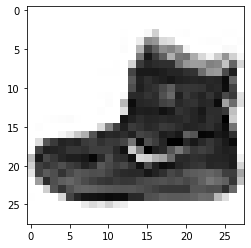

In [70]:
from matplotlib import cm
plt.imshow(X_train[0], cmap=cm.Greys)
print("Class:", isA(Y_train[0]))

On voit que l'element 0 est de la class `Ankle boot`

## 1. Test des differents algorithmes de classification

In [71]:
# Re shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

### K-nn

In [72]:
from sklearn.neighbors import KNeighborsClassifier

def executeKnn(X_train, Y_train, X_test, Y_test, k=5):
  # Create K-nn classifier
  knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
  t = time()
  # Train the classifier
  knn.fit(X_train, Y_train)
  print("training time: ", time() - t)

  # Test the classifier
  Y_pred = knn.predict(X_test)

  print("k = {:d} : {:.2%}".format(k, accuracy_score(Y_test, Y_pred)))

On se limite à un échantillon du dataset car le K-nn était trop lent à s'exécuter

In [73]:
nbTrain = X_train.shape[0]
print("Nb train", nbTrain)
nbTest = X_test.shape[0]
print("Nb test", nbTest)

divFactor = 8

nbTrainSample = round(nbTrain / divFactor)
print("Nb train sample", nbTrainSample)
nbTestSample = round(nbTest / divFactor)
print("Nb test sample", nbTestSample)

X_train_sample = X_train[:nbTrainSample]
Y_train_sample = Y_train[:nbTrainSample]
X_test_sample = X_test[:nbTestSample]
Y_test_sample = Y_test[:nbTestSample]

Nb train 60000
Nb test 10000
Nb train sample 7500
Nb test sample 1250


In [74]:
for k in range (1, 6):
  executeKnn(X_train_sample, Y_train_sample, X_test_sample, Y_test_sample, k)

training time:  0.544898509979248
k = 1 : 79.28%
training time:  0.5133836269378662
k = 2 : 80.64%
training time:  0.5168232917785645
k = 3 : 80.80%
training time:  0.5087499618530273
k = 4 : 80.88%
training time:  0.49982404708862305
k = 5 : 82.24%


### Classifieur bayésien

In [75]:
from sklearn.naive_bayes import GaussianNB

def executeBayes(X_train, Y_train, X_test, Y_test):
  # Create ML classifier
  knn = GaussianNB()
  t = time()
  # Train the classifier
  knn.fit(X_train, Y_train)
  print("training time: ", time() - t)

  # Test the classifier
  Y_pred = knn.predict(X_test)

  print("{:.2%}".format(accuracy_score(Y_test, Y_pred)))

In [76]:
executeBayes(X_train, Y_train, X_test, Y_test)

training time:  0.5331282615661621
58.56%


### Arbre de décision

In [77]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

def displayTree(dt, features_cols, class_names):
  dot_data = StringIO()
  export_graphviz(dt, out_file=dot_data,
                  filled=True, rounded=True,
                  special_characters=True,feature_names = features_cols,class_names=class_names)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png('fashion.png')
  Image(graph.create_png())

In [78]:
from sklearn.tree import DecisionTreeClassifier

def executeDecisionTree(X_train, Y_train, X_test, Y_test, display=False):
  # Create Decision Tree classifier
  dt = DecisionTreeClassifier(criterion='entropy')
  t = time()
  # Train the classifier
  dt.fit(X_train, Y_train)
  print("training time: ", time() - t)

  if display:
    features_cols = [str(k) for k in range(X_train.shape[1])]
    class_names = [str(k) for k in classes.keys()]
    displayTree(dt, features_cols, class_names)

  # Test the classifier
  Y_pred = dt.predict(X_test)

  print("{:.2%}".format(accuracy_score(Y_test, Y_pred)))

In [79]:
executeDecisionTree(X_train, Y_train, X_test, Y_test)

training time:  32.81132435798645
80.32%


On a trop de données donc l'arbre de décision est trop grand pour être affiché

Search best params

In [80]:
criterion = ['gini', 'entropy']
max_depth = [3, 5, 10]
min_samples_leaf = [1, 2, 5]
min_samples_split = [2, 3, 4]

best_params = None
best_score = 0
for c in criterion:
    for depth in max_depth:
        for l in min_samples_leaf:
            for s in min_samples_split:
                dt = DecisionTreeClassifier(criterion=c, max_depth=depth, min_samples_leaf=l, min_samples_split=s)
                dt.fit(X_train, Y_train)
                y_pred = dt.predict(X_test)
                scores = accuracy_score(Y_test, y_pred)
                if best_score==0 or scores > best_score:
                    best_score = scores
                    best_params = [c, depth, l, s]

print('Best Accuracy: ','{:2.2%}'.format(best_score))
print('Parameters: ', best_params)

Best Accuracy:  81.17%
Parameters:  ['entropy', 10, 1, 4]


### Forêts aléatoires

In [85]:
from sklearn.ensemble import RandomForestClassifier

def executeRandomForest(X_train, Y_train, X_test, Y_test):
  # Create Random Forest classifier
  rf = RandomForestClassifier()
  t = time()
  # Train the classifier
  rf.fit(X_train, Y_train)
  print("training time: ", time() - t)

  # Test the classifier
  Y_pred = dt.predict(X_test)

  print("{:.2%}".format(accuracy_score(Y_test, Y_pred)))

In [86]:
executeRandomForest(X_train, Y_train, X_test, Y_test)

training time:  84.11152672767639
81.08%


Search best params

In [83]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 5, 10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 5, 10, None], 'min_samples_split': [1, 2, 5], 'min_samples_leaf': [2, 3, 4], 'bootstrap': [True, False]}


In [87]:
if False:
  rf = RandomForestClassifier()
  rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                                cv = 3, verbose=2, random_state=42, n_jobs = -1)
  t = time()

  rf_random.fit(X_train, Y_train)
  print("training time: ", time() - t)

  Y_pred = dt.predict(X_test)
  print("{:.2%}".format(accuracy_score(Y_test, Y_pred)))
  rf_random.best_params_

On vois que TODO:

## 2. Comparaison des technique de reduction de dimension